In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
import seaborn as sns
import pandas as pd
import random
from sentence_transformers import SentenceTransformer
from few_shot_learning_nlp.few_shot_text_classification.setfit import SetFitTrainer
from few_shot_learning_nlp.few_shot_text_classification.setfit_dataset import SetFitDataset
from few_shot_learning_nlp.utils import stratified_train_test_split
from few_shot_learning_nlp.loss import FocalLoss

import warnings
warnings.filterwarnings("ignore")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## SetFit

In [4]:
model = SentenceTransformer("whaleloops/phrase-bert",
                            cache_folder= "/Data/pedro.silva/")

In [5]:
ag_news_dataset = load_dataset(
    "ag_news", 
    cache_dir= "/Data/pedro.silva"
)

dataset_name = "ag_news"

In [6]:
num_classes = len(ag_news_dataset['train']\
    .features['label']\
    .names)

classes_names = ag_news_dataset['train']\
    .features['label']\
    .names

num_classes

4

## Few shot learning approach - 50 shots

In [7]:
classes = np.unique(ag_news_dataset['train']['label'])

n_shots = 50

train_validation, test_df = stratified_train_test_split(
    ag_news_dataset['train'],
    classes,
    train_size = n_shots
)
train_df, val_df = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    30
)

In [8]:
val_df = pd.DataFrame(val_df).to_dict('list')
test_df = pd.DataFrame(test_df).sample(n = 1000).to_dict('list')

In [9]:
set_fit_data_train = SetFitDataset(
    train_df['text'],
    train_df['label'], 
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    val_df['text'], 
    val_df['label'],
    # R = 5,
    input_example_format= False
)

In [10]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=False
)

val_dataloader = DataLoader(
    set_fit_data_val
)

## Training embedding

In [11]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 128)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(128, 32)
        self.layer3 = torch.nn.Linear(32, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [12]:
embedding_model = SentenceTransformer(
    "whaleloops/phrase-bert",
    cache_folder="/Data/pedro.silva/"
).to(device)

in_features = embedding_model.get_sentence_embedding_dimension()

clf = CLF(
    in_features,
    num_classes,
).to(device)



trainer = SetFitTrainer(
    embedding_model,
    clf,
    num_classes
)

In [13]:
trainer.train_embedding(
    train_dataloader,
    val_dataloader,
    n_epochs=10,
)

f1 score: 0.7352941632270813
tensor([[147,   3],
        [ 15,  25]], device='cuda:0')


### Training classifier 

In [14]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff


In [15]:
_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

In [21]:


X_train_shuffled , y_train_shuffled = shuffle_two_lists(
    train_df['text'], 
    train_df['label']
)

history, embedding_model, clf = trainer.train_classifier(
    X_train_shuffled,
    y_train_shuffled,
    val_df['text'],
    val_df['label'],
    loss_fn= FocalLoss(alpha,2),
    clf = CLF(in_features, num_classes),
    n_epochs=15,
    lr = 1e-4
)

---------Epoch: 14-----------
f1 score: 0.8500000238418579
tensor([[2, 0, 1, 2],
        [0, 5, 0, 0],
        [0, 0, 5, 0],
        [0, 0, 0, 5]], device='cuda:0')


In [22]:
best_epoch = 0
best_f1 = np.max(history)
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [23]:
best_epoch

14

Text(0.5, 1.0, 'SetFit training results- AG news - 50 shots')

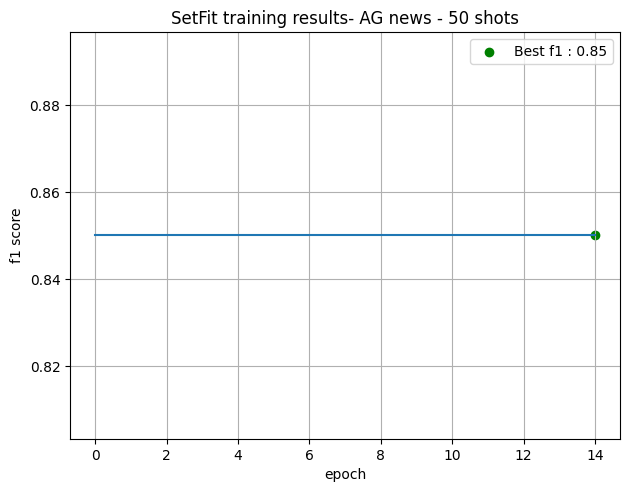

In [24]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- AG news - 50 shots")

## Inference

In [25]:
y_true, y_pred = trainer.test(test_df)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:08<00:00, 122.26it/s]


In [30]:
f1 = multiclass_f1_score(
    y_pred,
    y_true,
    num_classes=num_classes
)
f1

tensor(0.7840, device='cuda:0')

In [28]:
conf_matrix = multiclass_confusion_matrix(
    y_true.to(torch.int64),
    y_pred.to(torch.int64),
    num_classes
)

Text(0.5, 1.0, 'Confusion Matrix ag_news - SetFit - 50 shots')

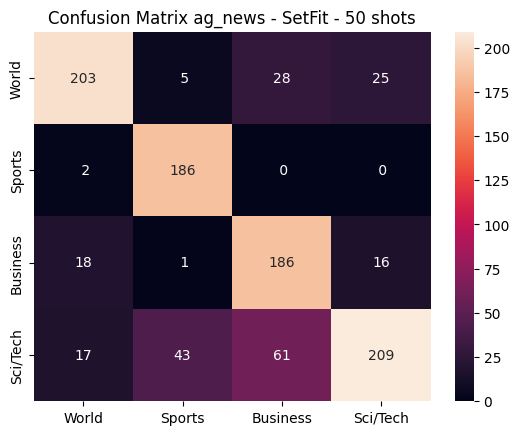

In [29]:
df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - SetFit - {n_shots} shots")